In [2]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
import numpy as np
keras.__version__

'2.2.4-tf'

## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

In [7]:
latent_dim = 64
height = 64
width = 64
channels = 3

In [8]:
generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.BatchNormalization(momentum = 0.5)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=4, padding='same')(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization(momentum = 0.5)(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             2129920   
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_v2_6 (Ba (None, 16, 16, 256)       1024

# The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

In [9]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0   

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [10]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0003, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

In [11]:
iterations = 20000
batch_size = 30

In [12]:
save_dir = '/gpfs_home/guest309/p2/genimgs'
imgdir = '/gpfs_home/guest309/p2/anime/data'

In [22]:
files = np.random.choice(os.listdir(imgdir), replace=False, size=8)

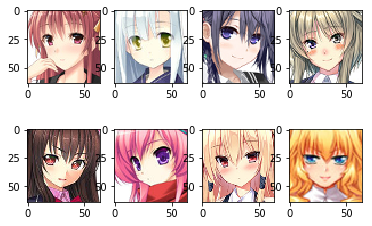

In [23]:
plt.figure(figsize=(6,4))
for i, file in enumerate(files):
    plt.subplot(2,4,i+1)
    img = plt.imread(imgdir + '/{}'.format(file))
    plt.imshow(img)

In [16]:
trainfiles = np.random.choice(os.listdir(imgdir), replace=False, size=10000)

In [7]:
x_train = []
for file in trainfiles:
    img = plt.imread(imgdir + '/{}'.format(file))
    x_train.append(img)
x_train = np.array(x_train)

In [ ]:
x_train.shape

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[1])

In [ ]:
# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_waifu' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, str(step) + '.png'))

Let's display a few of our fake images:

In [9]:
generator.save("g.h5")

In [26]:
from tensorflow.keras.models import load_model

In [27]:
generator = load_model("g.h5")

W0503 16:08:14.745600 140334798100288 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


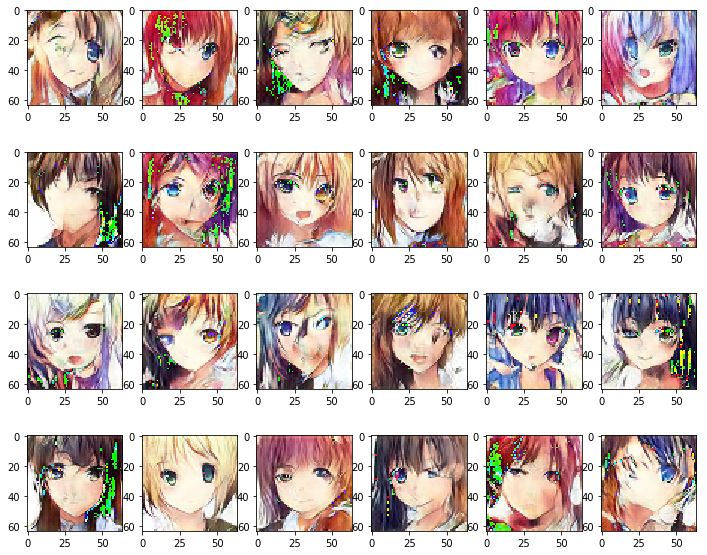

In [45]:
# added channel in generator 
# increased learning rate   
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(24, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)
plt.figure(figsize=(12,10))
for i in range(generated_images.shape[0]):
    plt.subplot(4,6,i+1)
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.imshow(img)
    
plt.show()  

Froggy with some pixellated artifacts.